#### SHAP values

SHAP (SHapley Additive exPlanations) is a game-theoretic approach used to explain the output of any machine learning model by calculating the contribution of each feature to a specific prediction. 

In [13]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import shap



In [2]:
device = torch.device("cuda")

In [3]:
# Here I am training a model on the MNIST data

batch_size = 128
num_epochs = 2

# The CNN
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
                f"\tLoss: {loss.item():.6f}"
            )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f},"
        f" Accuracy: {correct}/{len(test_loader.dataset)}"
        f" ({100.0 * correct / len(test_loader.dataset):.0f}%)\n"
    )


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist_data",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor()]),
    ),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("mnist_data", train=False, transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size,
    shuffle=True,
)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293846
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.225394
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.401482
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.895608
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.685435

Test set: Average loss: 0.0044, Accuracy: 8985/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.832463
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.665571
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.468850
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.646584
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.313393

Test set: Average loss: 0.0024, Accuracy: 9405/10000 (94%)



In [21]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch
images = images.to(device)

background = images[:100]
test_images = images[100:103]

# Get SHAP Values
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)



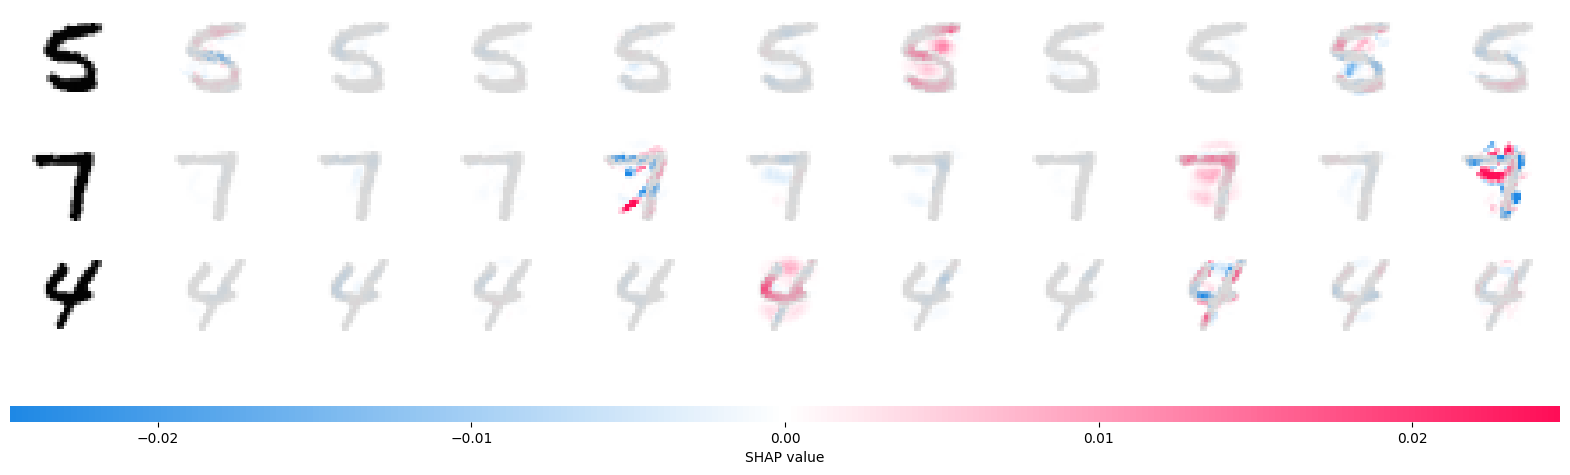

In [20]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().detach().numpy(), 1, -1), 1, 2)# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)



#### This SHAP explanation output shows the contribution of each pixel to the model's prediction for each digit. Here's how to interpret it: ####
Key Elements:

    Images on the Left: The leftmost column shows the original images from your dataset.
    SHAP Values (Right Columns): The rest of the image grid displays the SHAP values, which indicate how each pixel contributes to the prediction.
        Red regions: Pixels that positively contribute to the model's confidence in predicting the given digit (i.e., they push the prediction towards that class).
        Blue regions: Pixels that negatively contribute, meaning these pixels push the model away from predicting that class.

What It Is Showing:

For each row (digit):

    Red areas highlight important pixels that increase the model’s confidence in predicting the digit.
    Blue areas show pixels that decrease the confidence for predicting that digit.

